In [99]:
import numpy as np
import pandas as pd
import glob
import os
import datetime
import matplotlib.pyplot as plt
import pickle
import json
from tqdm import tqdm

### Define important dates

In [100]:
launch_date = datetime.datetime(2023,2,28)
launch_date = launch_date.date()

public_date = datetime.datetime(2024,2,6)
public_date = public_date.date()

brazil_twitter_ban = datetime.datetime(2024,8,30)
brazil_twitter_ban = brazil_twitter_ban.date()

ban_lift = datetime.datetime(2024,10,8)
ban_lift = ban_lift.date()

block_policy = datetime.datetime(2024,10,16)
block_policy = block_policy.date()

elections = datetime.datetime(2024,11,5)
elections = elections.date()

### Read files

#### Get profile creations

In [ ]:
profile_creations = pd.read_parquet('/N/project/INCAS/bluesky/profile_creations/profile_creations.parquet')

agg_profile_creations = profile_creations.groupby(['date','language'])['count'].sum()

agg_profile_creations = pd.DataFrame(agg_profile_creations).reset_index()

agg_profile_creations = agg_profile_creations.sort_values('date')

agg_profile_creations = agg_profile_creations[agg_profile_creations['date']>datetime.date(2023,8,18)]

agg_profile_creations_sum = agg_profile_creations.pivot_table(index='date', values='count', aggfunc='sum')

### Define the start and end days of groups
- Start dates are 2 days before the actual external shock happens
- End dates are found using a threshold of the rolling mean

In [102]:
intervals = {"public_date_group_interval": {"start":datetime.date(2024,2,4), "end":None},
            "brazil_ban_interval": {"start":datetime.date(2024,8,28), "end":None},
            "block_policy_change_interval": {"start":datetime.date(2024,10,14), "end":None},
            "election_interval": {"start":datetime.date(2024,11,2), "end":None}}

In [103]:
def get_stabilized_index(data, window_size=2, stabilize_threshold=.02):
    rolling_mean = data.rolling(window=window_size).mean()
    rolling_var = data.rolling(window=window_size).var()
    # calculate the percentage difference between 2 consecutive rolling mean and variance
    # if the difference is less than *stabilize_threshold* then the time series is stabilized, return the index (date) when timeseries has stabilized
    for i in rolling_mean.index[:-1]:
        mean_diff = abs(rolling_mean[i + 1] - rolling_mean[i]) / rolling_mean[i]
        var_diff = abs(rolling_var[i + 1] - rolling_var[i]) / rolling_var[i]
        if mean_diff <= stabilize_threshold or var_diff <= stabilize_threshold:
            print(
                f"Time series stabilized at index: {i}, data: {rolling_mean[i], rolling_mean[i+1]}"
            )
            print(f"Mean difference: {mean_diff}")
            print(f"Variance difference: {var_diff}")
            return i

In [132]:
for event, v in intervals.items():
    start_date = v['start']
    d = agg_profile_creations_sum[agg_profile_creations_sum.index >= start_date].reset_index(drop=True)['count']
    print(event)
    days_later = get_stabilized_index(d, 5, .01)
    end_date = start_date + datetime.timedelta(days_later)
    print(start_date, "->", end_date)
    intervals[event]["end"] = end_date
    print('------------------------------\n')

public_date_group_interval
Time series stabilized at index: 15, data: (7833.8, 7879.6)
Mean difference: 0.005846460210881077
Variance difference: 0.29225987452281615
2024-02-04 -> 2024-02-19
------------------------------

brazil_ban_interval
Time series stabilized at index: 36, data: (8151.2, 7559.2)
Mean difference: 0.07262734321326922
Variance difference: 0.0017953372180776186
2024-08-28 -> 2024-10-03
------------------------------

block_policy_change_interval
Time series stabilized at index: 46, data: (53794.0, 49458.4)
Mean difference: 0.08059634903520836
Variance difference: 0.0029180661855038436
2024-10-14 -> 2024-11-29
------------------------------

election_interval
Time series stabilized at index: 27, data: (53794.0, 49458.4)
Mean difference: 0.08059634903520836
Variance difference: 0.002918066185504566
2024-11-02 -> 2024-11-29
------------------------------



In [ ]:
# overwrite the end date of the block policy change so that there is no overlap
intervals['block_policy_change_interval']['end'] = datetime.date(2024,11,1)

In [ ]:
#with open('/N/project/INCAS/bluesky/profile_creations/user_group_date_intervals.pickle', 'wb') as f:
#    pickle.dump(intervals, f)

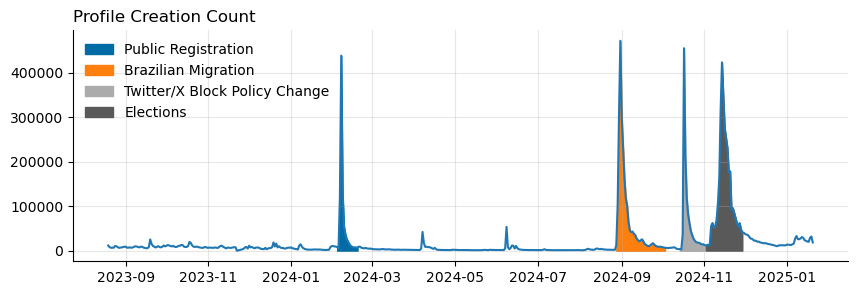

In [137]:
fig, axs = plt.subplots(1,1,figsize=(10,3))

FILTER = agg_profile_creations_sum.index > datetime.date(2023,8,18)

axs.plot(agg_profile_creations_sum[FILTER]['count'])

colors = ['#006ba4', '#ff800e', '#ababab', '#595959']
labels = ['Public Registration', 'Brazilian Migration', 'Twitter/X Block Policy Change', 'Elections']
i = 0
for event, v in intervals.items():
    start_date, end_date = v['start'], v['end']
    FILTER = (agg_profile_creations_sum.index >= start_date) & (agg_profile_creations_sum.index <= end_date)
    axs.fill_between(agg_profile_creations_sum[FILTER].index,
                     agg_profile_creations_sum[FILTER]['count'],
                     color=colors[i],
                     label=labels[i]
                     )
    i += 1

axs.set_title('Profile Creation Count', loc='left')
for dir in ['top', 'right']:
    axs.spines[dir].set_visible(False)
axs.grid(alpha=.3)
axs.legend(frameon=False)
fig.show()

## **Get user sets**

In [ ]:
user_groups = {}

# iterate over groups
for group_name, v in intervals.items():
    start_date, end_date = v['start'], v['end']
    FILTER = (profile_creations['date'] >= start_date) & (profile_creations['date'] <= end_date)

    user_groups[group_name] = set(profile_creations[FILTER]['author'])

#with open('/N/project/INCAS/bluesky/profile_creations/user_groups.pickle', 'wb') as f:
#    pickle.dump(user_groups, f)